# Lab 7: Pitch Tracking and Modifications
Gizem Tabak (tabak2)

In [65]:
%matplotlib inline
import scipy.signal as sgn
import scipy.io.wavfile as wv
import matplotlib.pyplot as plt
import numpy as np
import IPython
from matplotlib import mlab as mlab
from os.path import join

plt.rcParams["figure.figsize"] = (12, 6)

## Part 1: Making a pitch tracker

_In this section we will design a pitch tracker. We will apply it on the sound file beauty.wav included in the lab archive.
We want to find the pitch of the singing over time, as well as if the sound is pitched or not at any point in time. To do so we will design an autocorrelation pitch tracker._

In [66]:
fs, s = wv.read('data/beauty.wav')
s = s/max(abs(s))
print('Beauty')
IPython.display.display(IPython.display.Audio(s, rate=fs))

Beauty


In [67]:
def stft( input_sound, fs, dft_size, hop_size, zero_pad, window):
    if len(np.shape(input_sound)) == 1:
        # Forward transform
        input_sound_padded = np.zeros(len(input_sound) + dft_size - zero_pad + hop_size - len(input_sound)%hop_size)
        input_sound_padded[:len(input_sound)] = input_sound
        L = len(input_sound_padded) -  dft_size
        stft_output = np.zeros([int((dft_size)/2) + 1, int(L/hop_size)], dtype=complex)
        for i in range(0, int(L/hop_size)):
            seg = input_sound_padded[(i*hop_size):(i*hop_size + dft_size - zero_pad)]
            # Choose and apply window if selected
            if window == 'triangular':
                seg = np.multiply(seg, np.bartlett(dft_size - zero_pad))
            elif window == 'hann':
                seg = np.multiply(seg, np.hanning(dft_size - zero_pad))
            elif window == 'hamming':
                seg = np.multiply(seg, np.hamming(dft_size - zero_pad))
            elif window == 'kaiser':
                seg = np.multiply(seg, np.kaiser(dft_size - zero_pad, beta=0.8))
            # Change size variable so that it will pad zeros to input    
            s_stft = np.fft.rfft(seg, dft_size)            
            stft_output[:,i] = s_stft
            
        X = np.arange(0, (int(L/hop_size)*hop_size)/fs, hop_size/fs)
        Y = np.arange(0, fs/2, fs/(2*(int((dft_size)/2) + 1)))
        # # Make zero elements equal to the smallest value to avoid log(0) for plotting
        # min_nonzero = np.min(stft_output[np.nonzero(stft_output)])
        # stft_output[stft_output == 0] = min_nonzero
# 
        # plt.pcolormesh(X, Y, (np.abs(stft_output)**0.5), cmap='gist_gray_r')
        # plt.xlabel('Time (sec)')
        # plt.ylabel('Freq (Hz)')
        # plt.title('DFT=%d HOP=%d PAD=%d WINDOW=%s' %(dft_size, hop_size, zero_pad, window))
        # plt.grid(alpha=0.5)
        # plt.colorbar()
        # plt.show()

        return stft_output, X, Y
    elif len(np.shape(input_sound)) == 2:
        # Inverse transform
        L = (np.shape(input_sound)[1]+1)*hop_size
        stft_output = np.zeros([int(L)+hop_size,])
        for i in range(0, int((L - dft_size)/hop_size)):
            s_stft = np.fft.irfft(input_sound[:,i], dft_size)
            if len(window) > 0:
                # Window should only cover nonzero part, not zero paddings
                if window == 'triangular':
                    w = np.bartlett(dft_size - zero_pad)
                elif window == 'hann':
                    w = np.hanning(dft_size - zero_pad)
                elif window == 'hamming':
                    w = np.hamming(dft_size - zero_pad)
                elif window == 'kaiser':
                    w = np.kaiser(dft_size - zero_pad, beta=0.8)
                # Pad window with zeros to make dimensions equal
                window_padded = np.concatenate([w, np.zeros([zero_pad,])])
                s_stft = np.multiply(s_stft, window_padded)
            # Overlap and add
            stft_output[i*hop_size:(i*hop_size + dft_size)] += s_stft
        
        return stft_output

If the pitch is 100 Hz, it means the signal (approximately) repeats itself at every $\frac{f_s}{100}$ samples, hence $P_U=\frac{f_s}{100}$. This will be the upper limit of our pitch detetion range. Similarly, $P_L=\frac{f_s}{300}$ will be the lower end of the range, both in terms of samples. 

If we had performed autocorrelation in the time domain, the resulting (half-side of) $c$ would have $N$ samples, each corresponding to one sample shift of the original signal. However, when we calculate autocorrelation by computing the inverse DFT of the autocorrelation computed in the frequency domain, we map those $N$ samples into $[0,\text{NDFT/2}]$, where $N$ is the frame length. Thus, in order to limit the pitch range in the resulting autocorrelation array of size $\text{NDFT/2}+1$, we need to map lower and upper limits of the sample range into this new range, which will result in

$P_U = P_U*\dfrac{\text{NDFT}/2+1}{N} = \dfrac{f_s}{100}*\dfrac{\text{NDFT}/2+1}{N}$

$P_L = P_L*\dfrac{\text{NDFT}/2+1}{N} = \dfrac{f_s}{300}*\dfrac{\text{NDFT}/2+1}{N}$

In [96]:
dft_size = 4096
zero_pad = int(dft_size/2)
hop_size = int(dft_size/8)
window = []
s_stft, t, f = stft(s, fs, dft_size, hop_size, zero_pad, window)
pitch = np.zeros(np.size(s_stft,1))
f_pitch = np.zeros(np.size(s_stft,1))
Pl = (fs*(dft_size//2+1))/(300.*(dft_size - zero_pad))
Pu = (fs*(dft_size//2+1))/(100.*(dft_size - zero_pad))
mask = (np.arange(dft_size//2+1) > Pl) & (np.arange(dft_size//2+1) < Pu)
for i in range(np.size(s_stft, 1)):
    c_dft = np.conj(s_stft[:,i])*s_stft[:,i]
    c = np.fft.irfft(c_dft, dft_size)
    c = c[:(dft_size//2+1)]
    if max(c[mask]) > 0.7*c[0]:
        pitch[i] = ((np.argmax(c[mask]) + np.floor(Pl) + 1)*(dft_size - zero_pad))/(dft_size//2+1)
        f_pitch[i] = fs/pitch[i]

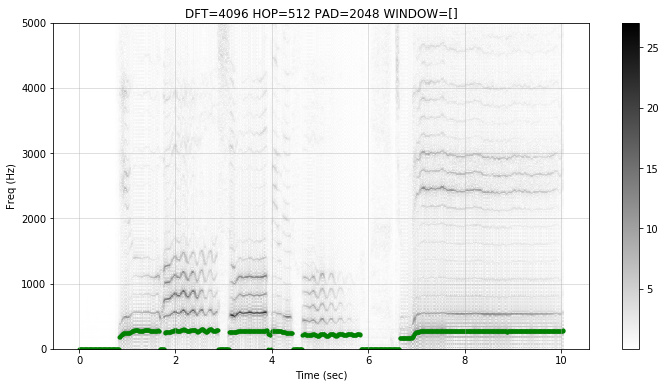

In [97]:
min_nonzero = np.min(s_stft[np.nonzero(s_stft)])
s_stft[s_stft == 0] = min_nonzero

plt.pcolormesh(t, f, (np.abs(s_stft)**0.5), cmap='gist_gray_r')
plt.xlabel('Time (sec)')
plt.ylabel('Freq (Hz)')
plt.title('DFT=%d HOP=%d PAD=%d WINDOW=%s' %(dft_size, hop_size, zero_pad, window))
plt.grid(alpha=0.5)
plt.colorbar()
plt.scatter(t, f_pitch, marker='.',facecolor='green')
plt.ylim([0, 5000])
plt.show()

## Part 2: Changing Pitch

When I focus on the fundamental pitch, I can see the deviations from the pitch in the last section of the clip much more clear.

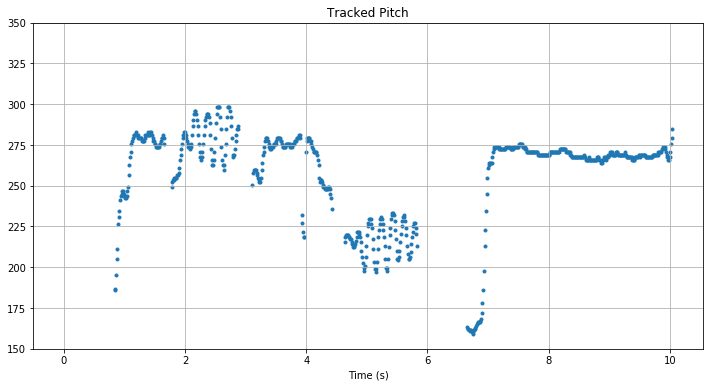

In [98]:
plt.scatter(t, f_pitch, marker='.')
plt.ylim([150, 350])
plt.grid()
plt.xlabel('Time (s)')
plt.title('Tracked Pitch')
plt.show()

I implemented a low-pass filter with cut-off frequency at 300 Hz. The resulting signal was clear and it was easy to extract pitch from zero-crossings. 

(When I tried correcting the pitch starting from 303000, it did not sound natural around the time she transitioned from `m` to `e`. So I left that part unchanged to keep it natural, and started correcting the pitch later in the `ee` part, samples starting from 308090.)

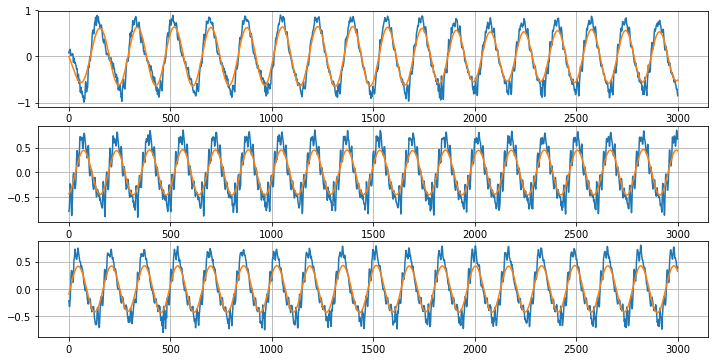

In [99]:
s_bad = s[308090:445000]
b, a = sgn.iirfilter(5, 300/(fs/2), btype='lowpass')
s_bad_filt = sgn.filtfilt(b, a, s_bad)
plt.subplot(311)
plt.plot(s_bad[:3000])
plt.plot(s_bad_filt[:3000])
plt.grid()
plt.subplot(312)
plt.plot(s_bad[10000:13000])
plt.plot(s_bad_filt[10000:13000])
plt.grid()
plt.subplot(313)
plt.plot(s_bad[50000:53000])
plt.plot(s_bad_filt[50000:53000])
plt.grid()
plt.show()

When I correct the pitch by re-aligning them, the resulting signal sounded much more in tune, although a little bit less natural.

In [100]:
n_correct = round(fs/274)
zc_mask = (((s_bad_filt[:-1] <= 0) + (s_bad_filt[1:] > 0)) == 0)
v = np.arange(len(s_bad_filt)-1)
zc_idx = v[zc_mask]
s_bad_corrected = np.zeros((len(zc_idx)-1)*n_correct)
for i in range(len(zc_idx)-2):
    seg = s_bad[zc_idx[i]:zc_idx[i+2]]
    seg = seg*np.hanning(len(seg))
    s_bad_corrected[(i*n_correct):(i*n_correct+len(seg))] += seg

s_corrected = np.concatenate((s[:308090], s_bad_corrected, s[445000:]))
print('Original')
IPython.display.display(IPython.display.Audio(s, rate=fs))
print('Corrected')
IPython.display.display(IPython.display.Audio(s_corrected, rate=fs))

Original


Corrected


In order to make sure the pitch is actually corrected, I implemented the pitch tracking algorithm in Part 1 on the corrected signal. Looking at the resulting plot, it seems the pitch is indeed corrected and the sound is snipped at 274 Hz.

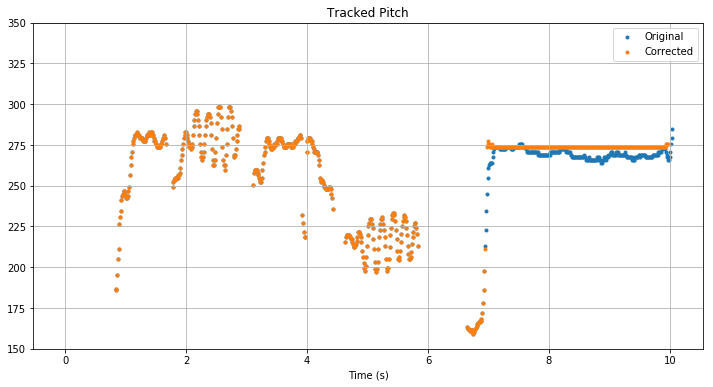

In [101]:
dft_size = 4096
zero_pad = int(dft_size/2)
hop_size = int(dft_size/8)
window = []
s_corrected_stft, t_corrected, f = stft(s_corrected, fs, dft_size, hop_size, zero_pad, window)
pitch_corrected   = np.zeros(np.size(s_corrected_stft,1))
f_pitch_corrected = np.zeros(np.size(s_corrected_stft,1))
Pl = (fs*(dft_size//2+1))/(300.*(dft_size - zero_pad))
Pu = (fs*(dft_size//2+1))/(100.*(dft_size - zero_pad))
mask = (np.arange(dft_size//2+1) > Pl) & (np.arange(dft_size//2+1) < Pu)
for i in range(np.size(s_corrected_stft, 1)):
    c_corrected_dft = np.conj(s_corrected_stft[:,i])*s_corrected_stft[:,i]
    c_corrected = np.fft.irfft(c_corrected_dft, dft_size)
    c_corrected = c_corrected[:(dft_size//2+1)]
    if max(c_corrected[mask]) > 0.7*c_corrected[0]:
        pitch_corrected[i] = ((np.argmax(c_corrected[mask]) + np.floor(Pl) + 1)*(dft_size - zero_pad))/(dft_size//2+1)
        f_pitch_corrected[i] = fs/pitch_corrected[i]
        
        
plt.scatter(t, f_pitch, marker='.')
plt.scatter(t_corrected, f_pitch_corrected, marker='.')
plt.ylim([150, 350])
plt.grid()
plt.xlabel('Time (s)')
plt.title('Tracked Pitch')
plt.legend(['Original', 'Corrected'])
plt.show()

## Changing Pitch #2

In order to move the (average) pitch to the correct note while keeping the sound more natural with the subtle vibrations, I tried changing the pitch at a different value instead of 274 Hz. to find which pitch value to use for each frame, I calculated the average of 20 frames and moved this average to 274, which corresponds to:

$f_{new}[i] = f[i] - \dfrac{1}{20}\sum_{k=0}^{19}f[i+k] + 274$

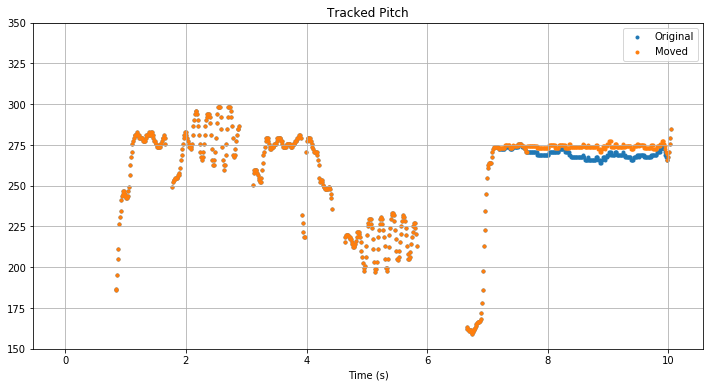

In [154]:
f_pitch_moved = np.copy(f_pitch)
l = 20
for i in range(len(f_pitch)//l):
    if i*l > len(t)*0.7:
        f_pitch_moved[(i*l):(i+1)*l] = f_pitch[(i*l):(i+1)*l] - np.mean(f_pitch[(i*l):(i+1)*l]) + 274

plt.scatter(t, f_pitch, marker='.')
plt.scatter(t, f_pitch_moved, marker='.')
plt.ylim([150, 350])
plt.grid()
plt.xlabel('Time (s)')
plt.title('Tracked Pitch')
plt.legend(['Original', 'Moved'])
plt.show()

In [156]:
s_last = s[(len(s)*7)//10:]
b, a = sgn.iirfilter(5, 300/(fs/2), btype='lowpass')
s_last_filt = sgn.filtfilt(b, a, s_last)

zc_mask_m = (((s_last_filt[:-1] <= 0) + (s_last_filt[1:] > 0)) == 0)
v = np.arange(len(s_last_filt)-1)
zc_idx_m = v[zc_mask_m]
s_moved_end = np.zeros((len(s)*4)//10)
n_last = 0
for i in range(len(zc_idx_m)-2):
    seg = s_last[zc_idx_m[i]:zc_idx_m[i+2]]
    seg = seg*np.hanning(len(seg))
    s_moved_end[n_last:(n_last+len(seg))] += seg
    nn = int(fs/f_pitch_moved[round((n_last+(len(s)*7)//10)*(len(t)/len(s)))])
    # print(f_pitch_moved[round((n_last+(len(s)*7)//10)*(len(t)/len(s)))], round((n_last+(len(s)*7)//10)*(len(t)/len(s))))
    n_last += nn

s_moved = np.concatenate((s[:(len(s)*7)//10], s_moved_end))
print('Original')
IPython.display.display(IPython.display.Audio(s, rate=fs))
print('Corrected')
IPython.display.display(IPython.display.Audio(s_moved, rate=fs))

Original


Corrected


Moving the tune to 274 Hz while keeping the subtle variations indeed made it sound more natural.

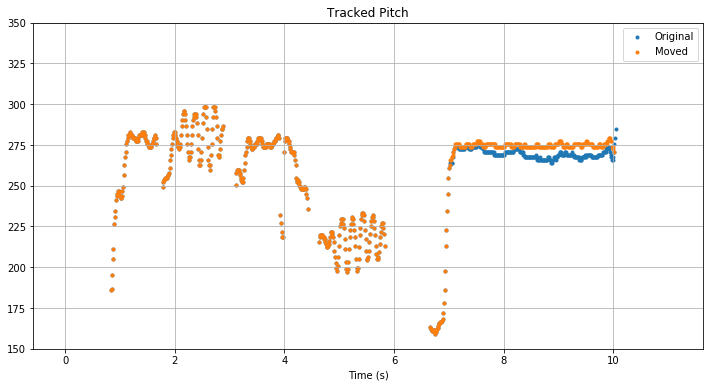

In [158]:
dft_size = 4096
zero_pad = int(dft_size/2)
hop_size = int(dft_size/8)
window = []
s_moved_stft, t_moved, f = stft(s_moved, fs, dft_size, hop_size, zero_pad, window)
pitch_est   = np.zeros(np.size(s_moved_stft,1))
f_pitch_est = np.zeros(np.size(s_moved_stft,1))
Pl = (fs*(dft_size//2+1))/(300.*(dft_size - zero_pad))
Pu = (fs*(dft_size//2+1))/(100.*(dft_size - zero_pad))
mask = (np.arange(dft_size//2+1) > Pl) & (np.arange(dft_size//2+1) < Pu)
for i in range(np.size(s_moved_stft, 1)):
    c_moved_dft = np.conj(s_moved_stft[:,i])*s_moved_stft[:,i]
    c_moved = np.fft.irfft(c_moved_dft, dft_size)
    c_moved = c_moved[:(dft_size//2+1)]
    if max(c_moved[mask]) > 0.7*c_moved[0]:
        pitch_est[i] = ((np.argmax(c_moved[mask]) + np.floor(Pl) + 1)*(dft_size - zero_pad))/(dft_size//2+1)
        f_pitch_est[i] = fs/pitch_est[i]
        
plt.scatter(t, f_pitch, marker='.')
plt.scatter(t_moved, f_pitch_est, marker='.')
plt.ylim([150, 350])
plt.grid()
plt.xlabel('Time (s)')
plt.title('Tracked Pitch')
plt.legend(['Original', 'Moved'])
plt.show()